In [1]:
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import pearsonr

### Data 

In [2]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-30,30)).sel(lon=slice(120,270)).sel(time=slice('1900-01', '2014-12'))
# Detrend 
sst_detrend = np.apply_along_axis(func.detrend_2step, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)

In [3]:
# Calculate Nino34 index
nino34 = func.nino34_index(sst_dt, '1979-01', '2008-12')
# Calculate monthly anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# Calculate EOFs
eof, pcs, var = func.eof_and_pcs(anom, 2)

In [4]:
# Normalise pc1
pc1 = pcs.sel(mode=1)*(-1)
std1 = pc1.sel(time=slice('1979-01', '2008-12')).std() # Takhashi usues standrd deviatuion of base period 
pc1 = pc1/std1

In [5]:
el_nino_years_sst, la_nina_years_sst = func.find_event_years(nino34, 0.4, 5)
el_nino_years_eof, la_nina_years_eof = func.find_event_years(pc1, 0.4, 5)

In [44]:
for i in np.arange(0.4, 0.8, 0.1):
    for j in np.arange(3, 7, 1):
        el_nino_years_sst, la_nina_years_sst = func.find_event_years(nino34, i, j)
        el_nino_years_eof, la_nina_years_eof = func.find_event_years(pc1, i, j)
        print(f'Threshold: {i}, Duration: {j}, EN SST: {len(el_nino_years_sst)}, EN EOF: {len(el_nino_years_eof)}, LN SST {len(la_nina_years_sst)}, LN EOF {len(la_nina_years_eof)}')

Threshold: 0.4, Duration: 3, EN SST: 34, EN EOF: 48, LN SST 45, LN EOF 49
Threshold: 0.4, Duration: 4, EN SST: 34, EN EOF: 44, LN SST 43, LN EOF 44
Threshold: 0.4, Duration: 5, EN SST: 33, EN EOF: 39, LN SST 41, LN EOF 40
Threshold: 0.4, Duration: 6, EN SST: 24, EN EOF: 37, LN SST 37, LN EOF 35
Threshold: 0.5, Duration: 3, EN SST: 34, EN EOF: 44, LN SST 41, LN EOF 43
Threshold: 0.5, Duration: 4, EN SST: 31, EN EOF: 41, LN SST 37, LN EOF 39
Threshold: 0.5, Duration: 5, EN SST: 25, EN EOF: 38, LN SST 33, LN EOF 34
Threshold: 0.5, Duration: 6, EN SST: 18, EN EOF: 34, LN SST 30, LN EOF 31
Threshold: 0.6, Duration: 3, EN SST: 26, EN EOF: 43, LN SST 34, LN EOF 35
Threshold: 0.6, Duration: 4, EN SST: 22, EN EOF: 37, LN SST 29, LN EOF 32
Threshold: 0.6, Duration: 5, EN SST: 17, EN EOF: 34, LN SST 28, LN EOF 29
Threshold: 0.6, Duration: 6, EN SST: 15, EN EOF: 27, LN SST 25, LN EOF 27
Threshold: 0.7, Duration: 3, EN SST: 20, EN EOF: 39, LN SST 25, LN EOF 32
Threshold: 0.7, Duration: 4, EN SST: 1

In [6]:
# Closest is threshold 0.4 and duration 5 
el_nino_years_sst, la_nina_years_sst = func.find_event_years(nino34, 0.4, 5)
el_nino_years_eof, la_nina_years_eof = func.find_event_years(pc1, 0.4, 5)

### Composites 

In [7]:
# El Nino, La Nina composites 

# Using NINO34 
el_nino_comp_sst, la_nina_comp_sst = func.sst_comp(nino34, sst_dt, 'DJF', 0.4, 5)
# Usng EOFs
el_nino_comp_eof, la_nina_comp_eof = func.sst_comp(pc1, sst_dt, 'DJF', 0.4, 5)

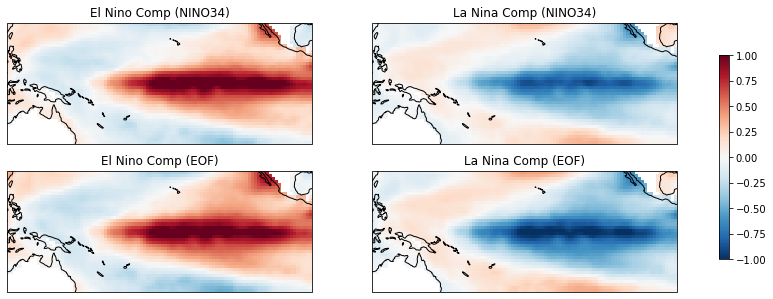

In [8]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = el_nino_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = la_nina_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = el_nino_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = la_nina_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
#plt.savefig('enso_comp_nino34_eof.jpg', bbox_inches='tight', dpi=300)

In [9]:
# Pattern corr
# Make 1d
el_nino_comp_sst_1d = el_nino_comp_sst.values.flatten()
la_nina_comp_sst_1d = la_nina_comp_sst.values.flatten()
el_nino_comp_eof_1d = el_nino_comp_eof.values.flatten()
la_nina_comp_eof_1d = la_nina_comp_eof.values.flatten()
# Apply mask 
el_nino_comp_sst_1d = el_nino_comp_sst_1d[np.isfinite(el_nino_comp_sst_1d)]
la_nina_comp_sst_1d = la_nina_comp_sst_1d[np.isfinite(la_nina_comp_sst_1d)]
el_nino_comp_eof_1d = el_nino_comp_eof_1d[np.isfinite(el_nino_comp_eof_1d)]
la_nina_comp_eof_1d = la_nina_comp_eof_1d[np.isfinite(la_nina_comp_eof_1d)]
# Correlation
el_nino_cor = pearsonr(el_nino_comp_sst_1d, el_nino_comp_eof_1d)
la_nina_cor = pearsonr(la_nina_comp_sst_1d, la_nina_comp_eof_1d)

In [10]:
print(f'El Nino Corr: {el_nino_cor[0]}, La Nina Corr: {la_nina_cor[0]}')

El Nino Corr: 0.9846033579580707, La Nina Corr: 0.9953427127825457


### EP and CP

In [11]:
# EP, CP years 

# Nino indices method
# Calculate Nino3 and Nino4
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = nino3 - 0.5*nino4
CP_sst = nino4 - 0.5*nino3
# Get EP and CP years 
seasonal_EP_sst = func.seasonal_mean_nino_index(EP_sst)
seasonal_CP_sst = func.seasonal_mean_nino_index(CP_sst)
djf_EP_sst = seasonal_EP_sst.sel(season='DJF')
djf_CP_sst = seasonal_CP_sst.sel(season='DJF')

In [12]:
# EOF method from Xu et al. 
# EP defined when standardised (DJF) PC1 > 1 std and > CP index (normalised (DJF) PC2)
# CP defined when standardised (DJF) PC2 > 0.8 std and > EP index (normalised (DJF) PC1)
# Normalise pc2
pc2 = pcs.sel(mode=2)
std2 = pc2.std()
pc2 = pc2/std2
# Seasonal index 
func.seasonyear(pc1)
seasonal_pc1 = pc1.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc1 = seasonal_pc1.sel(season='DJF')
func.seasonyear(pc2)
seasonal_pc2 = pc2.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc2 = seasonal_pc2.sel(season='DJF')
# E-index and C-index from Takahashi et al. 
E = (djf_pc1 - djf_pc2)/np.sqrt(2)
C = (djf_pc1 + djf_pc2)/np.sqrt(2)

In [16]:
for i in np.arange(0.4, 0.6, 0.1):
    for j in np.arange(0.6, 1.4, 0.2):
        EP_years = djf_EP_sst.where(djf_EP_sst>i, drop=True)
        CP_years = djf_CP_sst.where(djf_CP_sst>i, drop=True)
        E_years = E.where((E>j) & (E>C), drop=True)
        C_years = C.where((C>j) & (C>E), drop=True)
        print(f'EP/CP: {i}, E/C: {j}, EP years: {len(EP_years)}, E years: {len(E_years)}, CP years: {len(CP_years)}, C years: {len(C_years)}')

EP/CP: 0.4, E/C: 0.6, EP years: 11, E years: 19, CP years: 17, C years: 32
EP/CP: 0.4, E/C: 0.8, EP years: 11, E years: 17, CP years: 17, C years: 26
EP/CP: 0.4, E/C: 1.0, EP years: 11, E years: 13, CP years: 17, C years: 19
EP/CP: 0.4, E/C: 1.2000000000000002, EP years: 11, E years: 11, CP years: 17, C years: 15
EP/CP: 0.5, E/C: 0.6, EP years: 6, E years: 19, CP years: 11, C years: 32
EP/CP: 0.5, E/C: 0.8, EP years: 6, E years: 17, CP years: 11, C years: 26
EP/CP: 0.5, E/C: 1.0, EP years: 6, E years: 13, CP years: 11, C years: 19
EP/CP: 0.5, E/C: 1.2000000000000002, EP years: 6, E years: 11, CP years: 11, C years: 15


In [13]:
# Closest is EP/CP threshold: 0.4 and E/C threshold: 1.2
# Get years 
E_years = E.where((E>1) & (E>C), drop=True)
C_years = C.where((C>1) & (C>E), drop=True)
EP_years = djf_EP_sst.where(djf_EP_sst>0.4, drop=True)
CP_years = djf_CP_sst.where(djf_CP_sst>0.4, drop=True)

In [16]:
func.seasonyear(sst_dt)
seasonal_sst = sst_dt.groupby('seasonyear').apply(func.seasonal_mean)
sst_djf = seasonal_sst.sel(season='DJF')

In [18]:
# Find composites using years (EOF method) 
ep_comp_eof = (sst_djf.sel(seasonyear=E_years.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_eof = (sst_djf.sel(seasonyear=C_years.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
# Find composites using years (NINO method) 
ep_comp_sst = (sst_djf.sel(seasonyear=EP_years.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_sst = (sst_djf.sel(seasonyear=CP_years.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')

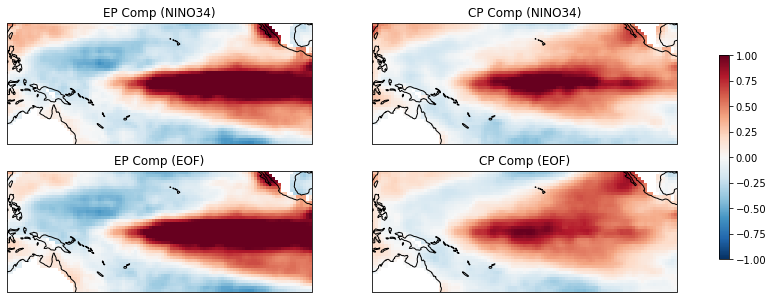

In [19]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = ep_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = cp_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = ep_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = cp_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
#plt.savefig('ep_cp_comp_nino34_eof.jpg', bbox_inches='tight', dpi=300)

In [20]:
# Pattern correlations
# Make 1d
ep_comp_sst_1d = ep_comp_sst.values.flatten()
cp_comp_sst_1d = cp_comp_sst.values.flatten()
ep_comp_eof_1d = ep_comp_eof.values.flatten()
cp_comp_eof_1d = cp_comp_eof.values.flatten()
# Apply mask 
ep_comp_sst_1d = ep_comp_sst_1d[np.isfinite(ep_comp_sst_1d)]
cp_comp_sst_1d = cp_comp_sst_1d[np.isfinite(cp_comp_sst_1d)]
ep_comp_eof_1d = ep_comp_eof_1d[np.isfinite(ep_comp_eof_1d)]
cp_comp_eof_1d = cp_comp_eof_1d[np.isfinite(cp_comp_eof_1d)]
# Correlation
ep_cor = pearsonr(ep_comp_sst_1d, ep_comp_eof_1d)
cp_cor = pearsonr(cp_comp_sst_1d, cp_comp_eof_1d)

In [21]:
print(f'EP Corr: {ep_cor[0]}, CP Corr: {cp_cor[0]}')

EP Corr: 0.9926546321614148, CP Corr: 0.9493685975163082
